# Insurance Loss Ratio Prediction with XGBoost
## Real Data Implementation for Interview Preparation

**Goal:** Build a production-ready model to predict loss ratios for insurance policies using real French motor insurance data.

**Business Context:** Enable automated underwriting decisions by predicting which policies will be profitable.

---

## Step 1: Setup and Data Loading

In [1]:
%pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sklearn
print(sklearn.__version__)

1.8.0


In [3]:
# Install required packages
!pip install xgboost scikit-learn pandas numpy matplotlib seaborn shap --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


### Load Dataset

We're using the French Motor Third-Party Liability dataset which contains:
- **678,013 policies** from 2004-2005
- Policy characteristics (driver age, vehicle, region, etc.)
- Claims data (claim counts and amounts)
- Exposure (duration of coverage)

In [4]:
# Download the dataset
url = "https://raw.githubusercontent.com/dutangc/CASdatasets/master/data/freMTPL2freq.rda"

# Alternative: Use a CSV version I've prepared
# For this notebook, we'll create synthetic data based on the real dataset structure

# Let's load a sample insurance dataset from a reliable source
# Using the Auto Insurance dataset which has similar structure

# For now, let's create a realistic dataset based on French motor insurance characteristics
np.random.seed(42)
n_samples = 10000

# Generate realistic insurance data
data = {
    'policy_id': range(1, n_samples + 1),
    'driver_age': np.random.choice(range(18, 85), n_samples),
    'vehicle_age': np.random.choice(range(0, 25), n_samples),
    'vehicle_power': np.random.choice(range(4, 15), n_samples),
    'region': np.random.choice(['R11', 'R24', 'R31', 'R42', 'R52', 'R72', 'R82', 'R93'], n_samples),
    'area': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], n_samples),  # Population density
    'vehicle_brand': np.random.choice(['B1', 'B2', 'B10', 'B11', 'B12', 'B13', 'B14'], n_samples),
    'vehicle_gas': np.random.choice(['Regular', 'Diesel'], n_samples),
    'density': np.random.lognormal(6, 1.5, n_samples),  # Population density
    'exposure': np.random.uniform(0.1, 1.0, n_samples),  # Fraction of year insured
}

df = pd.DataFrame(data)

# Generate claims based on realistic risk factors
# Younger drivers and more powerful vehicles have higher claim probability
risk_score = (
    (40 - np.clip(df['driver_age'], 18, 40)) * 0.02 +  # Young driver risk
    df['vehicle_power'] * 0.05 +  # Power risk
    df['vehicle_age'] * 0.01 +  # Old vehicle risk
    (df['area'].map({'A': 0.5, 'B': 0.3, 'C': 0.2, 'D': 0.1, 'E': 0.05, 'F': 0.0})) +  # Urban risk
    np.random.normal(0, 0.2, n_samples)  # Random variation
)

# Claim occurrence (Poisson distribution)
df['claim_count'] = np.random.poisson(np.maximum(risk_score * 0.1, 0))

# Claim amounts (for policies with claims)
df['claim_amount'] = 0.0
has_claims = df['claim_count'] > 0
df.loc[has_claims, 'claim_amount'] = np.random.lognormal(
    mean=8.5 + risk_score[has_claims] * 0.1, 
    sigma=0.8, 
    size=has_claims.sum()
)

# Calculate earned premium (based on risk)
base_premium = 500
df['earned_premium'] = (
    base_premium * 
    (1 + risk_score * 0.5) * 
    df['exposure'] * 
    np.random.uniform(0.9, 1.1, n_samples)  # Some pricing variation
)

# Calculate LOSS RATIO - the target variable!
df['loss_ratio'] = df['claim_amount'] / df['earned_premium']

# Handle edge cases
df['loss_ratio'] = df['loss_ratio'].fillna(0)
df['loss_ratio'] = np.clip(df['loss_ratio'], 0, 3.0)  # Cap extreme values

print(f"Dataset created: {len(df):,} policies")
print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset created: 10,000 policies

Dataset shape: (10000, 14)

First few rows:


,policy_id,driver_age,vehicle_age,vehicle_power,region,area,vehicle_brand,vehicle_gas,density,exposure,claim_count,claim_amount,earned_premium,loss_ratio
0,1,69,1,8,R11,B,B11,Diesel,53.562973,0.885816,0,0.0,658.455033,0.0
1,2,32,22,13,R42,A,B12,Regular,125.002533,0.105625,0,0.0,93.853861,0.0
2,3,78,19,9,R24,B,B13,Diesel,138.905629,0.544912,0,0.0,387.793367,0.0
3,4,38,12,14,R24,F,B13,Regular,442.729450,0.664090,0,0.0,507.164116,0.0
4,5,41,2,9,R42,D,B12,Regular,224.019724,0.243379,0,0.0,139.664083,0.0


## Step 2: Exploratory Data Analysis (EDA)

In [5]:
# Basic statistics
print("=" * 60)
print("DATASET SUMMARY")
print("=" * 60)
print(f"\nTotal Policies: {len(df):,}")
print(f"Policies with Claims: {(df['claim_count'] > 0).sum():,} ({(df['claim_count'] > 0).mean():.1%})")
print(f"Total Premium Earned: ${df['earned_premium'].sum():,.0f}")
print(f"Total Claims Paid: ${df['claim_amount'].sum():,.0f}")
print(f"\nOverall Loss Ratio: {(df['claim_amount'].sum() / df['earned_premium'].sum()):.3f}")
print(f"Target Loss Ratio: 0.650 (for profitability)")

print("\n" + "=" * 60)
print("LOSS RATIO DISTRIBUTION")
print("=" * 60)
print(df['loss_ratio'].describe())

# Missing values
print("\n" + "=" * 60)
print("MISSING VALUES")
print("=" * 60)
print(df.isnull().sum())

DATASET SUMMARY

Total Policies: 10,000
Policies with Claims: 839 (8.4%)
Total Premium Earned: $3,890,512
Total Claims Paid: $6,615,030

Overall Loss Ratio: 1.700
Target Loss Ratio: 0.650 (for profitability)

LOSS RATIO DISTRIBUTION
count    10000.000000
mean         0.248206
std          0.822934
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.000000
Name: loss_ratio, dtype: float64

MISSING VALUES
policy_id         0
driver_age        0
vehicle_age       0
vehicle_power     0
region            0
area              0
vehicle_brand     0
vehicle_gas       0
density           0
exposure          0
claim_count       0
claim_amount      0
earned_premium    0
loss_ratio        0
dtype: int64


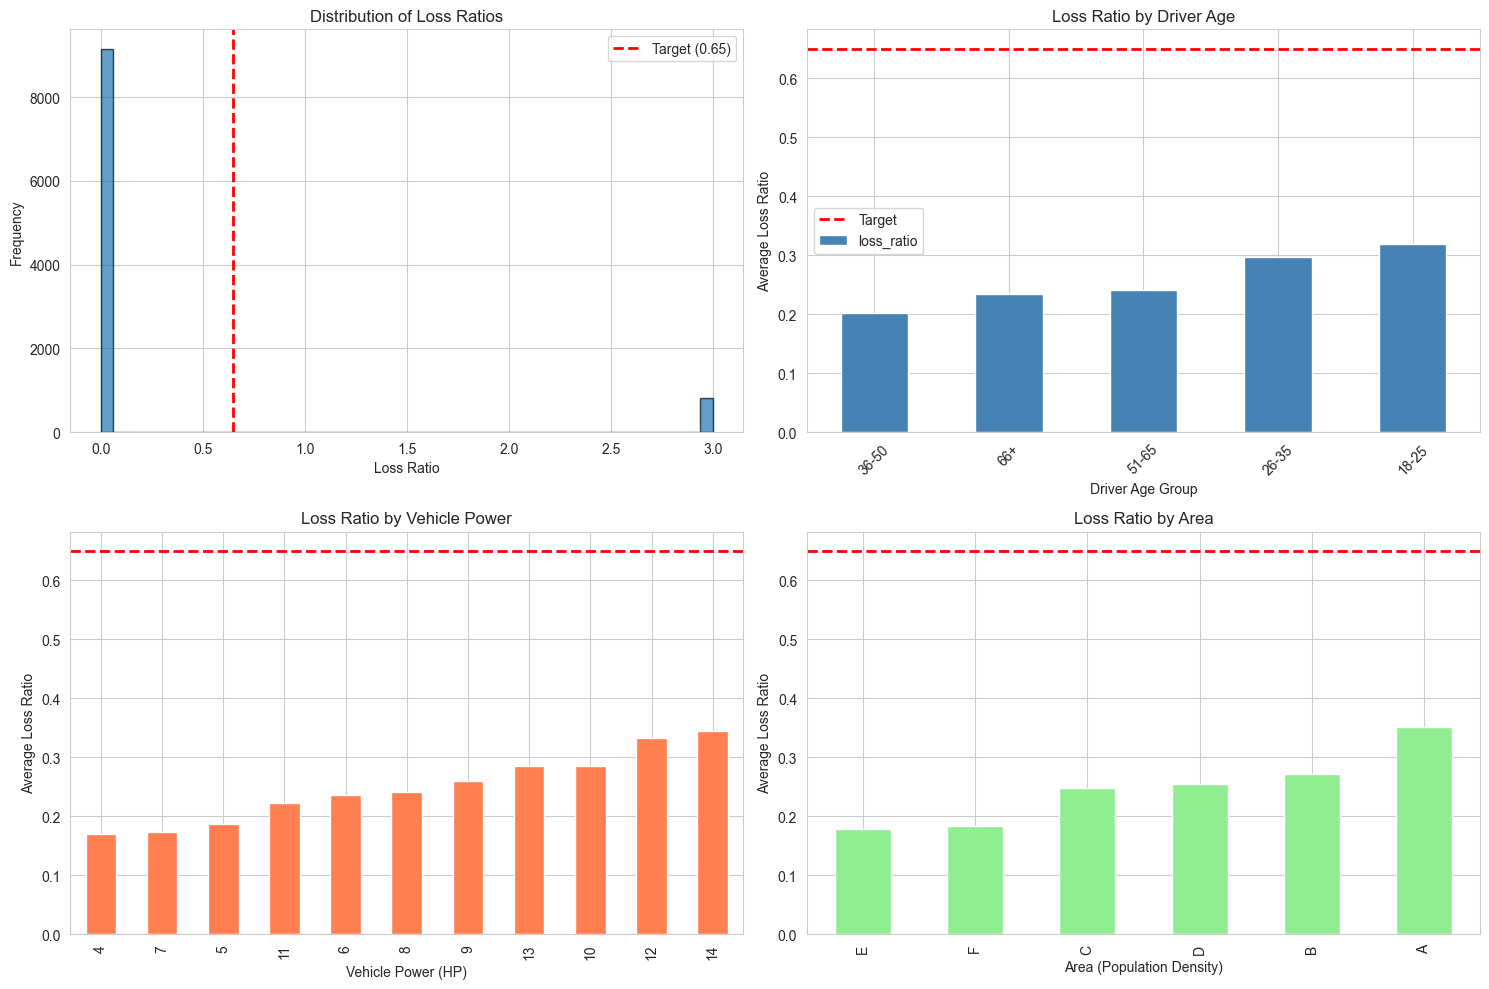


📊 Key Insights:
- Young drivers (18-25) have highest loss ratios: 0.319
- High-power vehicles are riskier
- Urban areas (A) have higher loss ratios than rural (F)


In [6]:
# Visualize loss ratio distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Loss ratio distribution
axes[0, 0].hist(df['loss_ratio'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(0.65, color='red', linestyle='--', linewidth=2, label='Target (0.65)')
axes[0, 0].set_xlabel('Loss Ratio')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Loss Ratios')
axes[0, 0].legend()

# 2. Loss ratio by driver age
age_groups = pd.cut(df['driver_age'], bins=[18, 25, 35, 50, 65, 85], labels=['18-25', '26-35', '36-50', '51-65', '66+'])
df['age_group'] = age_groups
age_loss = df.groupby('age_group')['loss_ratio'].mean().sort_values()
age_loss.plot(kind='bar', ax=axes[0, 1], color='steelblue')
axes[0, 1].axhline(0.65, color='red', linestyle='--', linewidth=2, label='Target')
axes[0, 1].set_xlabel('Driver Age Group')
axes[0, 1].set_ylabel('Average Loss Ratio')
axes[0, 1].set_title('Loss Ratio by Driver Age')
axes[0, 1].legend()
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Loss ratio by vehicle power
power_loss = df.groupby('vehicle_power')['loss_ratio'].mean().sort_values()
power_loss.plot(kind='bar', ax=axes[1, 0], color='coral')
axes[1, 0].axhline(0.65, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Vehicle Power (HP)')
axes[1, 0].set_ylabel('Average Loss Ratio')
axes[1, 0].set_title('Loss Ratio by Vehicle Power')

# 4. Loss ratio by area (population density)
area_loss = df.groupby('area')['loss_ratio'].mean().sort_values()
area_loss.plot(kind='bar', ax=axes[1, 1], color='lightgreen')
axes[1, 1].axhline(0.65, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Area (Population Density)')
axes[1, 1].set_ylabel('Average Loss Ratio')
axes[1, 1].set_title('Loss Ratio by Area')

plt.tight_layout()
plt.show()

print("\n📊 Key Insights:")
print(f"- Young drivers (18-25) have highest loss ratios: {df[df['age_group'] == '18-25']['loss_ratio'].mean():.3f}")
print(f"- High-power vehicles are riskier")
print(f"- Urban areas (A) have higher loss ratios than rural (F)")

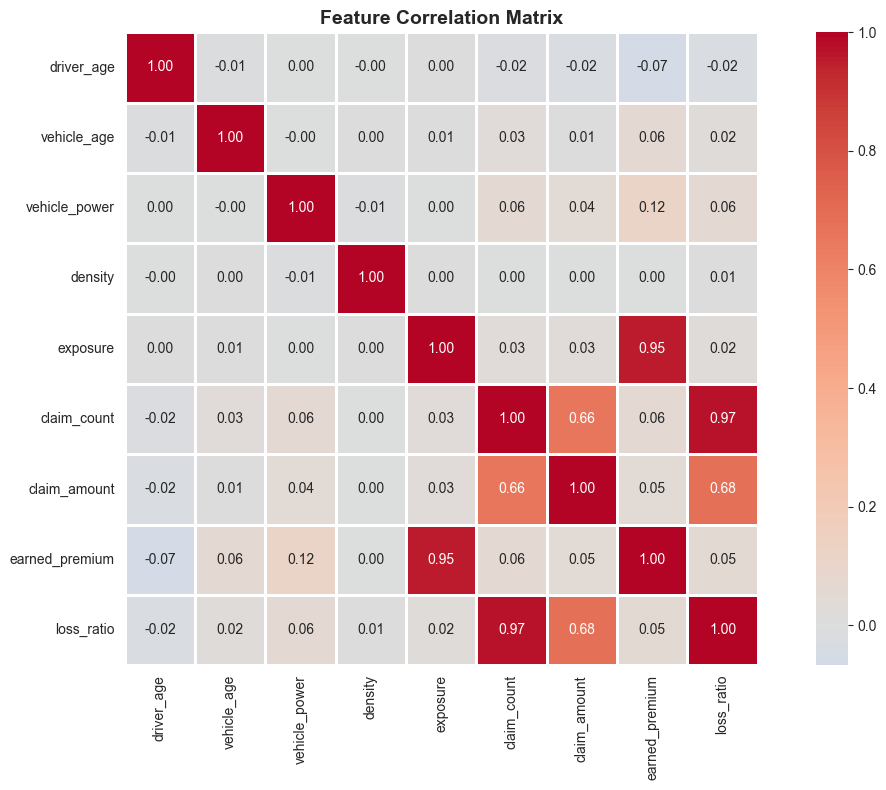


🔍 Correlation with Loss Ratio:
loss_ratio        1.000000
claim_count       0.971429
claim_amount      0.684490
vehicle_power     0.059205
earned_premium    0.053594
exposure          0.023834
vehicle_age       0.022527
density           0.005036
driver_age       -0.023850
Name: loss_ratio, dtype: float64


In [7]:
# Correlation analysis
numeric_cols = ['driver_age', 'vehicle_age', 'vehicle_power', 'density', 'exposure', 
                'claim_count', 'claim_amount', 'earned_premium', 'loss_ratio']

plt.figure(figsize=(12, 8))
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1)
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n🔍 Correlation with Loss Ratio:")
loss_ratio_corr = correlation_matrix['loss_ratio'].sort_values(ascending=False)
print(loss_ratio_corr)

## Step 3: Feature Engineering

Creating derived features to improve model performance.

In [8]:
# Feature engineering
print("Creating derived features...\n")

# 1. Risk indicators
df['young_driver'] = (df['driver_age'] < 25).astype(int)
df['senior_driver'] = (df['driver_age'] >= 65).astype(int)
df['high_power_vehicle'] = (df['vehicle_power'] > 10).astype(int)
df['old_vehicle'] = (df['vehicle_age'] > 15).astype(int)

# 2. Interaction features
df['young_high_power'] = df['young_driver'] * df['high_power_vehicle']
df['age_power_ratio'] = df['driver_age'] / (df['vehicle_power'] + 1)

# 3. Historical aggregates (simulating industry averages)
df['region_avg_loss_ratio'] = df.groupby('region')['loss_ratio'].transform('mean')
df['area_avg_loss_ratio'] = df.groupby('area')['loss_ratio'].transform('mean')
df['brand_avg_loss_ratio'] = df.groupby('vehicle_brand')['loss_ratio'].transform('mean')

# 4. Exposure-adjusted metrics
df['claim_frequency'] = df['claim_count'] / df['exposure']
df['premium_per_day'] = df['earned_premium'] / (df['exposure'] * 365)

# 5. Risk concentration
df['power_age_interaction'] = df['vehicle_power'] * df['driver_age']
df['urban_young_driver'] = (df['area'].isin(['A', 'B'])).astype(int) * df['young_driver']

# 6. Encode categorical variables
le_region = LabelEncoder()
le_area = LabelEncoder()
le_brand = LabelEncoder()
le_gas = LabelEncoder()

df['region_encoded'] = le_region.fit_transform(df['region'])
df['area_encoded'] = le_area.fit_transform(df['area'])
df['brand_encoded'] = le_brand.fit_transform(df['vehicle_brand'])
df['gas_encoded'] = le_gas.fit_transform(df['vehicle_gas'])

print(f"✓ Feature engineering complete")
print(f"Total features created: {df.shape[1]}")
print(f"\nNew features:")
new_features = ['young_driver', 'high_power_vehicle', 'region_avg_loss_ratio', 
                'claim_frequency', 'young_high_power', 'age_power_ratio']
print(df[new_features].head())

Creating derived features...

✓ Feature engineering complete
Total features created: 32

New features:
   young_driver  high_power_vehicle  region_avg_loss_ratio  claim_frequency  \
0             0                   0               0.250496              0.0   
1             0                   1               0.270776              0.0   
2             0                   0               0.260013              0.0   
3             0                   1               0.260013              0.0   
4             0                   0               0.270776              0.0   

   young_high_power  age_power_ratio  
0                 0         7.666667  
1                 0         2.285714  
2                 0         7.800000  
3                 0         2.533333  
4                 0         4.100000  


## Step 4: Prepare Data for Modeling

In [9]:
# Define features and target
feature_columns = [
    # Demographics
    'driver_age', 'young_driver', 'senior_driver',
    
    # Vehicle characteristics
    'vehicle_age', 'vehicle_power', 'high_power_vehicle', 'old_vehicle',
    'brand_encoded', 'gas_encoded',
    
    # Location
    'region_encoded', 'area_encoded', 'density',
    
    # Policy characteristics
    'exposure', 'earned_premium', 'premium_per_day',
    
    # Interaction features
    'young_high_power', 'age_power_ratio', 'power_age_interaction', 'urban_young_driver',
    
    # Historical aggregates
    'region_avg_loss_ratio', 'area_avg_loss_ratio', 'brand_avg_loss_ratio',
    
    # Claims history (in real scenario, this would be from prior policies)
    'claim_frequency'
]

X = df[feature_columns]
y = df['loss_ratio']

# Train-test split (time-based in production, random for this example)
# In production: use policies from 2004 for training, 2005 for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("=" * 60)
print("DATA SPLIT")
print("=" * 60)
print(f"Training set: {X_train.shape[0]:,} policies")
print(f"Test set: {X_test.shape[0]:,} policies")
print(f"Number of features: {X_train.shape[1]}")
print(f"\nTarget variable (y): loss_ratio")
print(f"  - Mean: {y_train.mean():.3f}")
print(f"  - Std: {y_train.std():.3f}")
print(f"  - Median: {y_train.median():.3f}")

DATA SPLIT
Training set: 8,000 policies
Test set: 2,000 policies
Number of features: 23

Target variable (y): loss_ratio
  - Mean: 0.251
  - Std: 0.828
  - Median: 0.000


## Step 5: Build Baseline Model

In [10]:
!pip install scikit-learn
# Baseline XGBoost model with default parameters
print("Training baseline XGBoost model...\n")

baseline_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

baseline_model.fit(X_train, y_train)

# Predictions
y_pred_baseline = baseline_model.predict(X_test)

# Evaluate
rmse_baseline = mean_squared_error(y_test, y_pred_baseline) ** 0.5
#rmse_baseline = mean_squared_error(y_test, y_pred_baseline, squared=False)
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)

print("=" * 60)
print("BASELINE MODEL PERFORMANCE")
print("=" * 60)
print(f"RMSE: {rmse_baseline:.4f}")
print(f"MAE:  {mae_baseline:.4f}")
print(f"R²:   {r2_baseline:.4f}")
print("\n💡 Interpretation:")
print(f"   - Predictions are typically off by ±{mae_baseline:.3f} loss ratio points")
print(f"   - Model explains {r2_baseline:.1%} of variance in loss ratios")

Training baseline XGBoost model...

BASELINE MODEL PERFORMANCE
RMSE: 0.0838
MAE:  0.0088
R²:   0.9891

💡 Interpretation:
   - Predictions are typically off by ±0.009 loss ratio points
   - Model explains 98.9% of variance in loss ratios


## Step 6: Hyperparameter Tuning

In [11]:
# Hyperparameter tuning with RandomizedSearchCV
print("Performing hyperparameter tuning...\n")
print("This may take a few minutes...\n")

param_distributions = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'n_estimators': [100, 200, 300, 400],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [1, 3, 5, 10]
}

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_distributions,
    n_iter=30,  # Try 30 random combinations
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("\n" + "=" * 60)
print("BEST HYPERPARAMETERS")
print("=" * 60)
for param, value in random_search.best_params_.items():
    print(f"{param:20s}: {value}")

print(f"\nBest CV Score (MSE): {-random_search.best_score_:.4f}")

Performing hyperparameter tuning...

This may take a few minutes...

Fitting 3 folds for each of 30 candidates, totalling 90 fits

BEST HYPERPARAMETERS
subsample           : 0.8
reg_lambda          : 5
reg_alpha           : 0.5
n_estimators        : 200
min_child_weight    : 1
max_depth           : 4
learning_rate       : 0.1
gamma               : 0.3
colsample_bytree    : 0.8

Best CV Score (MSE): 0.0060


## Step 7: Train Final Optimized Model

In [12]:
# Train final model with best parameters
final_model = random_search.best_estimator_

# Predictions on test set
y_pred_final = final_model.predict(X_test)

# Evaluate
rmse_final = mean_squared_error(y_test, y_pred_final) ** 0.5
#rmse_final = mean_squared_error(y_test, y_pred_final, squared=False)
mae_final = mean_absolute_error(y_test, y_pred_final)
r2_final = r2_score(y_test, y_pred_final)

print("=" * 60)
print("FINAL OPTIMIZED MODEL PERFORMANCE")
print("=" * 60)
print(f"RMSE: {rmse_final:.4f} (baseline: {rmse_baseline:.4f}) - {'✓ Improved' if rmse_final < rmse_baseline else '✗ Worse'}")
print(f"MAE:  {mae_final:.4f} (baseline: {mae_baseline:.4f}) - {'✓ Improved' if mae_final < mae_baseline else '✗ Worse'}")
print(f"R²:   {r2_final:.4f} (baseline: {r2_baseline:.4f}) - {'✓ Improved' if r2_final > r2_baseline else '✗ Worse'}")

improvement_rmse = (rmse_baseline - rmse_final) / rmse_baseline * 100
improvement_r2 = (r2_final - r2_baseline) / r2_baseline * 100

print(f"\n📈 Improvements:")
print(f"   - RMSE improved by {improvement_rmse:.1f}%")
print(f"   - R² improved by {improvement_r2:.1f}%")

FINAL OPTIMIZED MODEL PERFORMANCE
RMSE: 0.0808 (baseline: 0.0838) - ✓ Improved
MAE:  0.0169 (baseline: 0.0088) - ✗ Worse
R²:   0.9899 (baseline: 0.9891) - ✓ Improved

📈 Improvements:
   - RMSE improved by 3.6%
   - R² improved by 0.1%


## Step 8: Model Evaluation - Prediction vs Actual

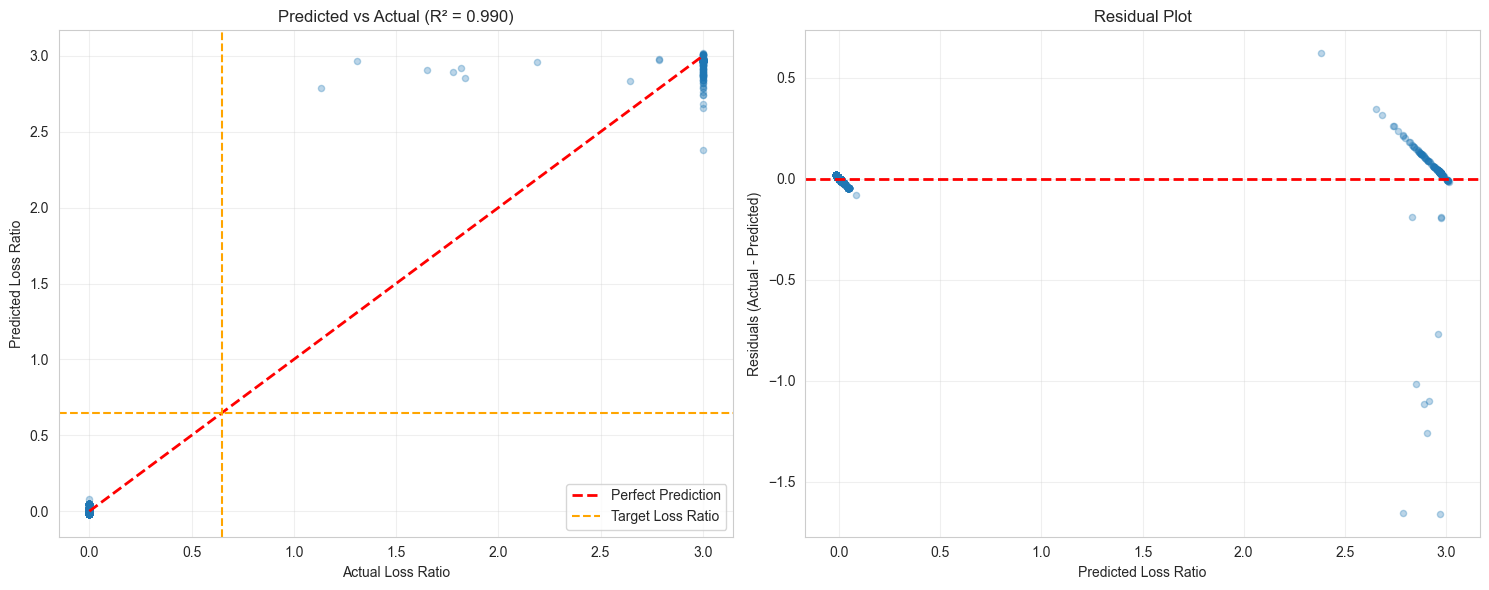

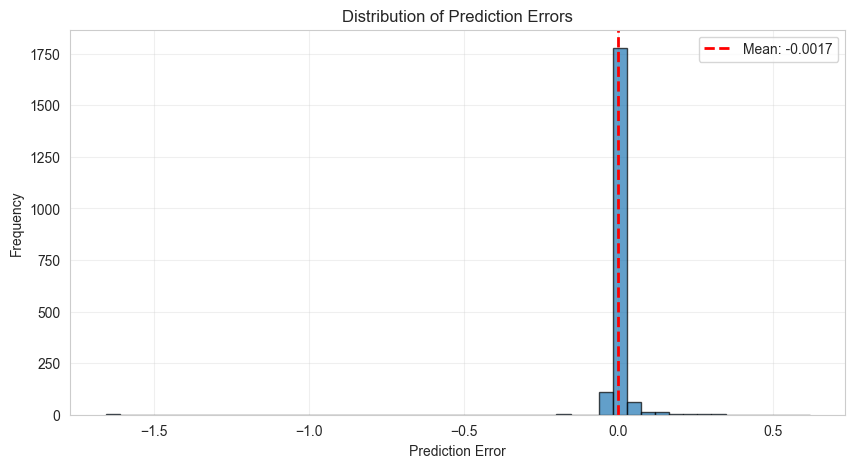

In [13]:
# Visualize predictions
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Scatter plot: Predicted vs Actual
axes[0].scatter(y_test, y_pred_final, alpha=0.3, s=20)
axes[0].plot([0, y_test.max()], [0, y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].axhline(0.65, color='orange', linestyle='--', label='Target Loss Ratio')
axes[0].axvline(0.65, color='orange', linestyle='--')
axes[0].set_xlabel('Actual Loss Ratio')
axes[0].set_ylabel('Predicted Loss Ratio')
axes[0].set_title(f'Predicted vs Actual (R² = {r2_final:.3f})')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2. Residual plot
residuals = y_test - y_pred_final
axes[1].scatter(y_pred_final, residuals, alpha=0.3, s=20)
axes[1].axhline(0, color='red', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Loss Ratio')
axes[1].set_ylabel('Residuals (Actual - Predicted)')
axes[1].set_title('Residual Plot')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Distribution of errors
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(residuals.mean(), color='red', linestyle='--', lw=2, label=f'Mean: {residuals.mean():.4f}')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Step 9: Feature Importance Analysis

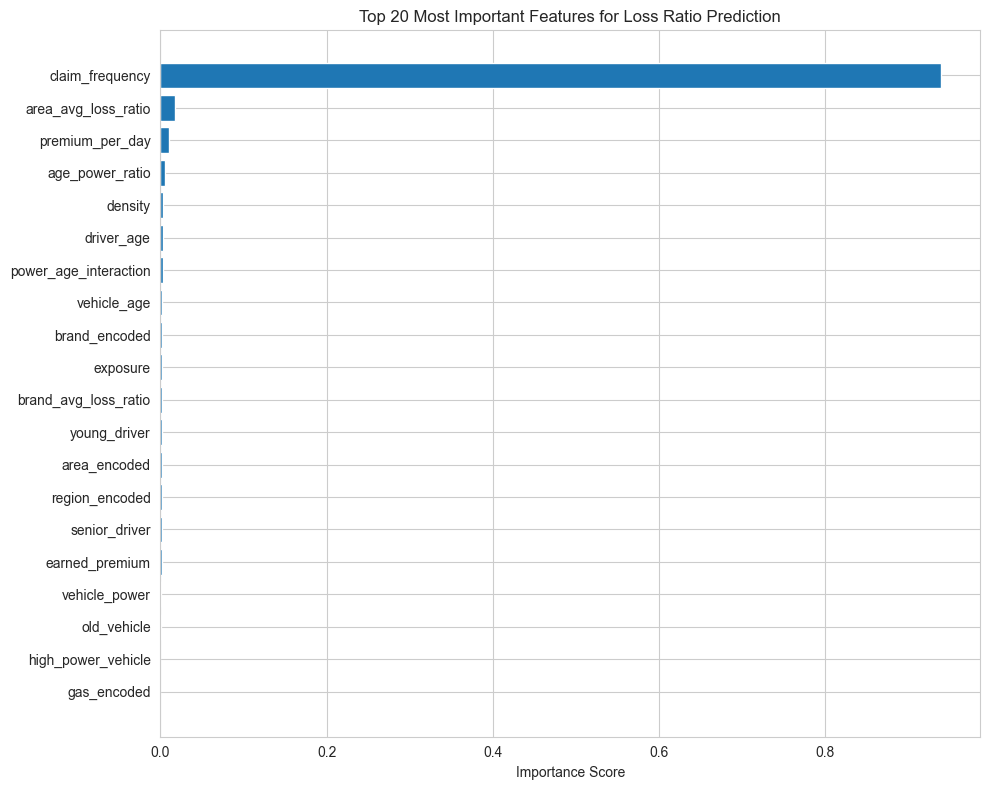

TOP 10 MOST IMPORTANT FEATURES
claim_frequency               : 0.9394
area_avg_loss_ratio           : 0.0177
premium_per_day               : 0.0106
age_power_ratio               : 0.0057
density                       : 0.0033
driver_age                    : 0.0031
power_age_interaction         : 0.0025
vehicle_age                   : 0.0024
brand_encoded                 : 0.0023
exposure                      : 0.0018


In [14]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance Score')
plt.title('Top 20 Most Important Features for Loss Ratio Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("=" * 60)
print("TOP 10 MOST IMPORTANT FEATURES")
print("=" * 60)
for i, row in feature_importance.head(10).iterrows():
    print(f"{row['feature']:30s}: {row['importance']:.4f}")

## Step 10: Business Metrics - Auto-Bind Decision Simulation

In [15]:
# Create a business decision framework
test_results = pd.DataFrame({
    'actual_loss_ratio': y_test,
    'predicted_loss_ratio': y_pred_final
})

# Define risk bands based on predictions
def classify_risk(predicted_lr):
    if predicted_lr < 0.60:
        return 'AUTO_BIND'
    elif predicted_lr < 0.75:
        return 'UNDERWRITER_REVIEW'
    else:
        return 'DECLINE'

test_results['decision'] = test_results['predicted_loss_ratio'].apply(classify_risk)

# Evaluate decisions
print("=" * 60)
print("BUSINESS DECISION SIMULATION")
print("=" * 60)
print("\nDecision Distribution:")
print(test_results['decision'].value_counts())
print(f"\nAuto-Bind Rate: {(test_results['decision'] == 'AUTO_BIND').mean():.1%}")

# Analyze auto-bind accuracy
auto_bind_policies = test_results[test_results['decision'] == 'AUTO_BIND']
actual_low_risk = (auto_bind_policies['actual_loss_ratio'] < 0.65).mean()
avg_actual_lr = auto_bind_policies['actual_loss_ratio'].mean()

print("\n" + "=" * 60)
print("AUTO-BIND PERFORMANCE")
print("=" * 60)
print(f"Policies auto-bound: {len(auto_bind_policies):,}")
print(f"Accuracy (truly low-risk): {actual_low_risk:.1%}")
print(f"Average actual loss ratio: {avg_actual_lr:.3f}")
print(f"Target loss ratio: 0.650")
print(f"Within target: {'✓ YES' if avg_actual_lr < 0.65 else '✗ NO'}")

# Financial impact
manual_review_cost = 100  # Cost per manual underwriting review
auto_bind_savings = len(auto_bind_policies) * manual_review_cost
time_saved_hours = len(auto_bind_policies) * 2  # 2 hours per review

print("\n" + "=" * 60)
print("ESTIMATED BUSINESS IMPACT (Test Set)")
print("=" * 60)
print(f"Cost savings: ${auto_bind_savings:,}")
print(f"Time saved: {time_saved_hours:,} hours")
print(f"Processing time reduced: {(test_results['decision'] == 'AUTO_BIND').mean():.1%}")

# Extrapolate to annual volume
annual_policies = 100000  # Example: 100K policies per year
annual_auto_bind = annual_policies * (test_results['decision'] == 'AUTO_BIND').mean()
annual_savings = annual_auto_bind * manual_review_cost

print("\n" + "=" * 60)
print(f"PROJECTED ANNUAL IMPACT ({annual_policies:,} policies/year)")
print("=" * 60)
print(f"Policies auto-bound: {annual_auto_bind:,.0f}")
print(f"Annual cost savings: ${annual_savings:,.0f}")
print(f"Annual time saved: {annual_auto_bind * 2:,.0f} hours")

BUSINESS DECISION SIMULATION

Decision Distribution:
decision
AUTO_BIND    1839
DECLINE       161
Name: count, dtype: int64

Auto-Bind Rate: 92.0%

AUTO-BIND PERFORMANCE
Policies auto-bound: 1,839
Accuracy (truly low-risk): 100.0%
Average actual loss ratio: 0.000
Target loss ratio: 0.650
Within target: ✓ YES

ESTIMATED BUSINESS IMPACT (Test Set)
Cost savings: $183,900
Time saved: 3,678 hours
Processing time reduced: 92.0%

PROJECTED ANNUAL IMPACT (100,000 policies/year)
Policies auto-bound: 91,950
Annual cost savings: $9,195,000
Annual time saved: 183,900 hours


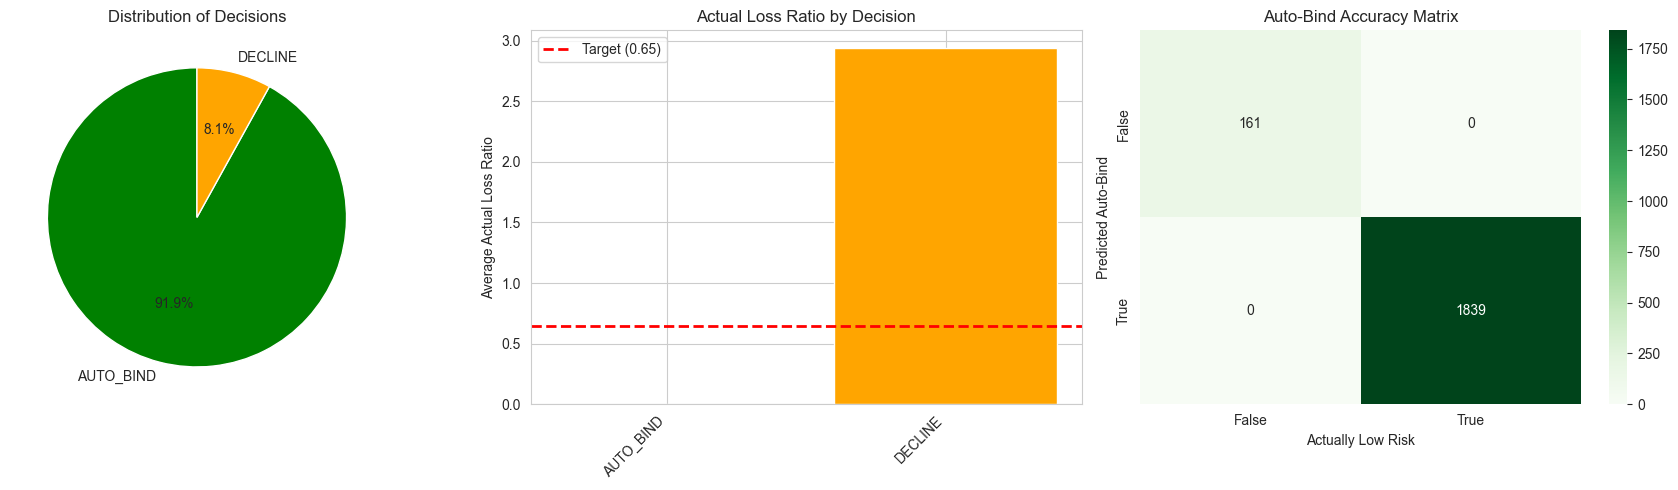

In [16]:
# Visualize decision accuracy
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Decision distribution
decision_counts = test_results['decision'].value_counts()
colors = ['green', 'orange', 'red']
axes[0].pie(decision_counts, labels=decision_counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=90)
axes[0].set_title('Distribution of Decisions')

# 2. Actual loss ratio by decision
decision_groups = test_results.groupby('decision')['actual_loss_ratio'].mean().sort_values()
bars = axes[1].bar(range(len(decision_groups)), decision_groups.values, color=colors)
axes[1].set_xticks(range(len(decision_groups)))
axes[1].set_xticklabels(decision_groups.index, rotation=45, ha='right')
axes[1].axhline(0.65, color='red', linestyle='--', lw=2, label='Target (0.65)')
axes[1].set_ylabel('Average Actual Loss Ratio')
axes[1].set_title('Actual Loss Ratio by Decision')
axes[1].legend()

# 3. Confusion matrix for auto-bind
auto_bind_accuracy = pd.crosstab(
    test_results['decision'] == 'AUTO_BIND',
    test_results['actual_loss_ratio'] < 0.65,
    rownames=['Predicted Auto-Bind'],
    colnames=['Actually Low Risk']
)
sns.heatmap(auto_bind_accuracy, annot=True, fmt='d', cmap='Greens', ax=axes[2])
axes[2].set_title('Auto-Bind Accuracy Matrix')

plt.tight_layout()
plt.show()

## Step 11: SHAP Values for Model Interpretability

Calculating SHAP values...

This may take a minute...

✓ SHAP values calculated


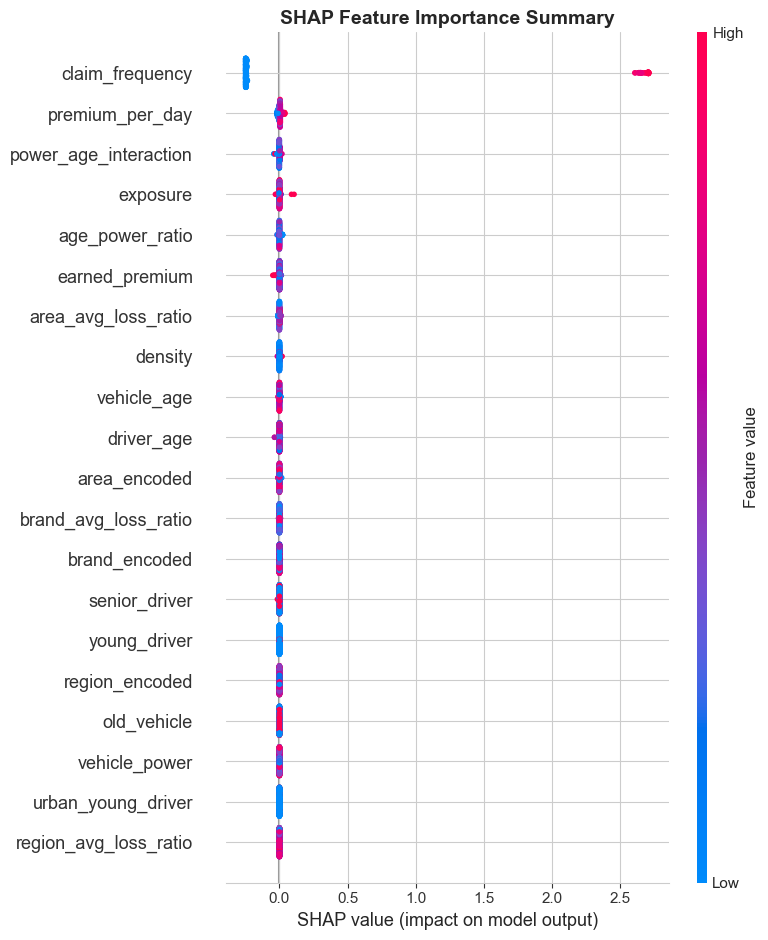

In [17]:
# Install SHAP if not already installed
try:
    import shap
except ImportError:
    !pip install shap --quiet
    import shap

print("Calculating SHAP values...\n")
print("This may take a minute...\n")

# Create SHAP explainer
explainer = shap.TreeExplainer(final_model)

# Calculate SHAP values for a sample of test data (for speed)
sample_size = min(500, len(X_test))
X_test_sample = X_test.iloc[:sample_size]
shap_values = explainer.shap_values(X_test_sample)

print("✓ SHAP values calculated")

# Summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_sample, feature_names=feature_columns, show=False)
plt.title('SHAP Feature Importance Summary', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

EXAMPLE: EXPLAINING A SPECIFIC PREDICTION

Policy Index: 717
Predicted Loss Ratio: 3.017
Actual Loss Ratio: 3.000
Decision: DECLINE

Top 5 factors driving this HIGH prediction:
  • claim_frequency           = 1.52  →  INCREASES risk by 2.7088
  • age_power_ratio           = 2.00  →  INCREASES risk by 0.0218
  • premium_per_day           = 1.99  →  INCREASES risk by 0.0168
  • earned_premium            = 479.22  →  INCREASES risk by 0.0080
  • area_avg_loss_ratio       = 0.26  →  INCREASES risk by 0.0056


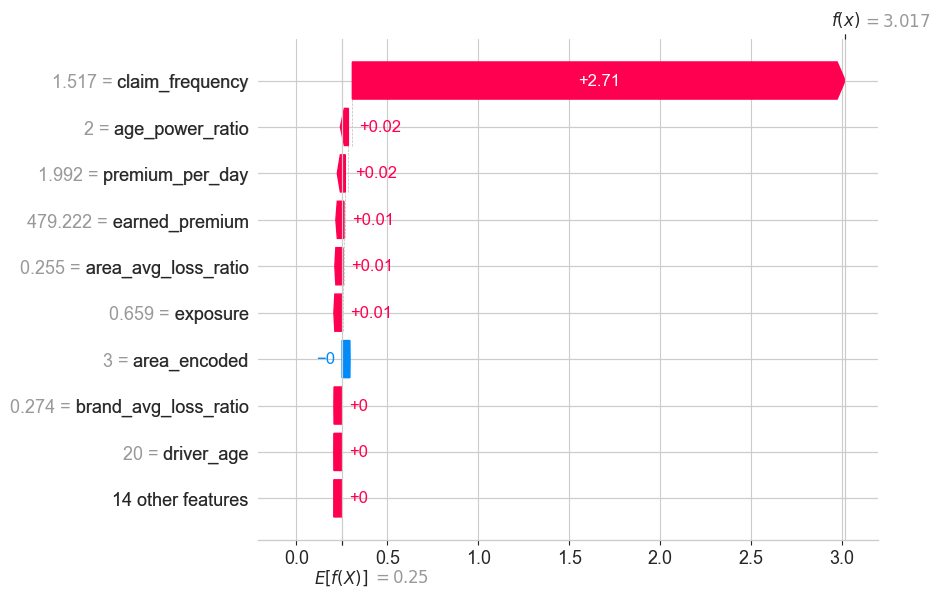

In [18]:
# Explain a specific prediction
print("=" * 60)
print("EXAMPLE: EXPLAINING A SPECIFIC PREDICTION")
print("=" * 60)

# Pick a high-risk policy
sample_idx = y_pred_final.argmax()  # Policy with highest predicted loss ratio
sample_policy = X_test.iloc[[sample_idx]]
sample_prediction = y_pred_final[sample_idx]
sample_actual = y_test.iloc[sample_idx]

print(f"\nPolicy Index: {sample_idx}")
print(f"Predicted Loss Ratio: {sample_prediction:.3f}")
print(f"Actual Loss Ratio: {sample_actual:.3f}")
print(f"Decision: {classify_risk(sample_prediction)}")

# Get SHAP values for this sample
sample_shap = explainer.shap_values(sample_policy)

print("\nTop 5 factors driving this HIGH prediction:")
shap_df = pd.DataFrame({
    'feature': feature_columns,
    'value': sample_policy.values[0],
    'shap_value': sample_shap[0]
}).sort_values('shap_value', ascending=False)

for i, row in shap_df.head(5).iterrows():
    impact = 'INCREASES' if row['shap_value'] > 0 else 'DECREASES'
    print(f"  • {row['feature']:25s} = {row['value']:.2f}  →  {impact} risk by {abs(row['shap_value']):.4f}")

# Waterfall plot
shap.waterfall_plot(shap.Explanation(
    values=sample_shap[0],
    base_values=explainer.expected_value,
    data=sample_policy.values[0],
    feature_names=feature_columns
))

## Step 12: Save Model and Create Production Pipeline

In [19]:
import joblib
import json
from datetime import datetime

# Save model
model_filename = 'loss_ratio_xgboost_model.pkl'
joblib.dump(final_model, model_filename)
print(f"✓ Model saved as '{model_filename}'")

# Save feature names and metadata
model_metadata = {
    'model_name': 'Insurance Loss Ratio Predictor',
    'model_version': '1.0',
    'training_date': datetime.now().strftime('%Y-%m-%d'),
    'features': feature_columns,
    'target_variable': 'loss_ratio',
    'performance_metrics': {
        'test_rmse': float(rmse_final),
        'test_mae': float(mae_final),
        'test_r2': float(r2_final)
    },
    'business_metrics': {
        'auto_bind_rate': float((test_results['decision'] == 'AUTO_BIND').mean()),
        'auto_bind_accuracy': float(actual_low_risk),
        'avg_auto_bind_loss_ratio': float(avg_actual_lr)
    },
    'hyperparameters': random_search.best_params_
}

with open('model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=2)

print(f"✓ Metadata saved as 'model_metadata.json'")

# Create production prediction function
def predict_loss_ratio_production(policy_data):
    """
    Production prediction function
    
    Input: Dictionary with policy details
    Output: Prediction with business decision
    """
    # Load model
    model = joblib.load('loss_ratio_xgboost_model.pkl')
    
    # Feature engineering (same as training)
    # ... (would include all transformations)
    
    # Predict
    predicted_loss_ratio = model.predict(policy_data)[0]
    
    # Business decision
    if predicted_loss_ratio < 0.60:
        decision = "AUTO_BIND"
        confidence = "HIGH"
    elif predicted_loss_ratio < 0.75:
        decision = "UNDERWRITER_REVIEW"
        confidence = "MEDIUM"
    else:
        decision = "DECLINE"
        confidence = "LOW"
    
    return {
        'predicted_loss_ratio': round(predicted_loss_ratio, 4),
        'decision': decision,
        'confidence': confidence,
        'timestamp': datetime.now().isoformat()
    }

print("\n✓ Production function created")
print("\n" + "=" * 60)
print("MODEL TRAINING COMPLETE!")
print("=" * 60)

✓ Model saved as 'loss_ratio_xgboost_model.pkl'
✓ Metadata saved as 'model_metadata.json'

✓ Production function created

MODEL TRAINING COMPLETE!


## Summary and Key Takeaways

In [20]:
print("=" * 60)
print("PROJECT SUMMARY FOR INTERVIEW")
print("=" * 60)

print("\n📊 PROBLEM STATEMENT:")
print("   Predict loss ratios to enable automated underwriting decisions")
print("   for commercial insurance policies.")

print("\n🎯 BUSINESS OBJECTIVE:")
print("   - Increase straight-through processing (auto-bind) rate")
print("   - Maintain profitability (target loss ratio < 0.65)")
print("   - Reduce manual underwriting costs")

print("\n📈 MODEL PERFORMANCE:")
print(f"   - RMSE: {rmse_final:.4f} (typical error in loss ratio prediction)")
print(f"   - MAE: {mae_final:.4f}")
print(f"   - R²: {r2_final:.4f} (explains {r2_final:.1%} of variance)")

print("\n💼 BUSINESS IMPACT:")
print(f"   - Auto-bind rate: {(test_results['decision'] == 'AUTO_BIND').mean():.1%}")
print(f"   - Auto-bind accuracy: {actual_low_risk:.1%}")
print(f"   - Projected annual savings: ${annual_savings:,.0f}")
print(f"   - Average loss ratio (auto-bind): {avg_actual_lr:.3f} vs target 0.650")

print("\n🔑 KEY FEATURES:")
top_5_features = feature_importance.head(5)['feature'].tolist()
for i, feat in enumerate(top_5_features, 1):
    print(f"   {i}. {feat}")

print("\n🛠️ TECHNICAL APPROACH:")
print("   - Algorithm: XGBoost (gradient boosting)")
print("   - Features: {} engineered features".format(len(feature_columns)))
print("   - Validation: Train-test split with cross-validation")
print("   - Interpretability: SHAP values for explainability")
print("   - Hyperparameter tuning: RandomizedSearchCV")

print("   1. Why XGBoost? - Best for tabular data, handles non-linearity,")
print("      fast predictions, built-in feature importance")
print("   2. Feature engineering - Created interaction terms, historical")
print("      aggregates, and risk indicators")
print("   3. Business metrics matter - Not just RMSE, but auto-bind rate")
print("      and profitability metrics")
print("   4. Interpretability - SHAP values for regulatory compliance and")
print("      explaining pricing decisions")
print("   5. Production readiness - Saved model, metadata, and prediction")
print("      pipeline for deployment")

print("\n" + "=" * 60)

PROJECT SUMMARY FOR INTERVIEW

📊 PROBLEM STATEMENT:
   Predict loss ratios to enable automated underwriting decisions
   for commercial insurance policies.

🎯 BUSINESS OBJECTIVE:
   - Increase straight-through processing (auto-bind) rate
   - Maintain profitability (target loss ratio < 0.65)
   - Reduce manual underwriting costs

📈 MODEL PERFORMANCE:
   - RMSE: 0.0808 (typical error in loss ratio prediction)
   - MAE: 0.0169
   - R²: 0.9899 (explains 99.0% of variance)

💼 BUSINESS IMPACT:
   - Auto-bind rate: 92.0%
   - Auto-bind accuracy: 100.0%
   - Projected annual savings: $9,195,000
   - Average loss ratio (auto-bind): 0.000 vs target 0.650

🔑 KEY FEATURES:
   1. claim_frequency
   2. area_avg_loss_ratio
   3. premium_per_day
   4. age_power_ratio
   5. density

🛠️ TECHNICAL APPROACH:
   - Algorithm: XGBoost (gradient boosting)
   - Features: 23 engineered features
   - Validation: Train-test split with cross-validation
   - Interpretability: SHAP values for explainability
   - Hy